In [6]:
import itertools as it

from keras.datasets import fashion_mnist

import keras
import keras.layers as kl
import keras.models as km
import keras.regularizers as kr

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

Wir definieren die globalen Parameter wie zuvor

In [2]:
batch_size = 128
num_classes = 10
epochs = 20

Auch die Datenvorberarbeitung erfolgt wie vorher, mit dem Unterschied, dass wir nun Fashion-MNIST von Zalando verwenden.

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

4423680/4422102 [==============================] - 2s 0us/step


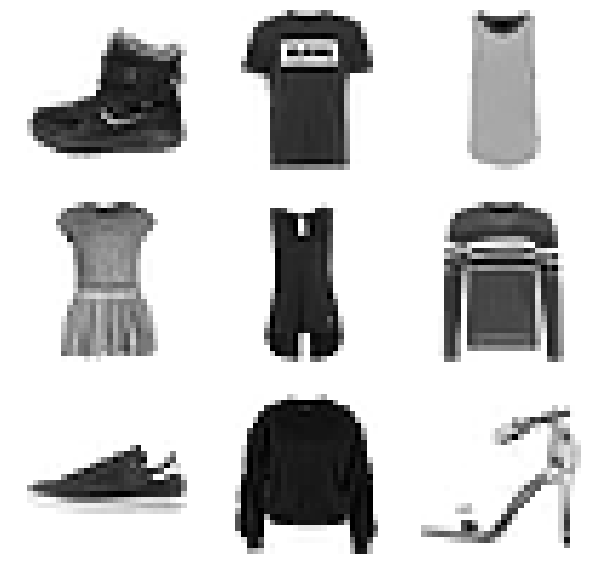

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for image, ax in zip(x_train, axes.flat):
    ax.imshow(image.reshape(28, 28), cmap='binary')
    ax.set_axis_off()

Anstatt das Modell direkt zu definieren, definieren wir eine Funktion, die ein Modell erzeugt. Die Argumente dieser Funktion sind die Hyperparameter des Modells. Dadurch können wir leicht verschiedene Parameter ausprobieren.

Um das Modell zu definieren, verwenden wir die [Funktionale API von Keras](https://keras.io/getting-started/functional-api-guide/). In dieser API werden die verschiedenen Layer zunächst erzeugt und dann auf einen Tensor angewendet. Die Rückgabe ist wieder ein Tensor, auf den andere Layer angewendet werden können. Auf diese Art können komplexe Netzwerke mit mehreren Ein- und Ausgabeschichten erzeugt werden.

In [14]:
def make_mnist_model(l2_reg=1e-4, dropout_p=0.2, layers=2, units=512, activation='relu', optimizer='adam'):

    image_input = kl.Input(shape=(784,))

    output = image_input
    
    regularizer = kr.l2(l2_reg)
    
    for layer in range(layers):
        output = kl.Dense(units, activation=activation, kernel_regularizer=regularizer)(output)
        if dropout_p > 0:
            output = kl.Dropout(dropout_p)(output)
            
    output = kl.Dense(10, activation='softmax', kernel_regularizer=regularizer)(output)
    
    mnist_model = km.Model(inputs=image_input, outputs=output)
    
    mnist_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return mnist_model

Nun definieren wir noch eine Funktion, die ein gegebenes Modell für eine bestimmte Anzahl an Epochen trainiert und auf den Testdaten evaluiert.

In [15]:
def run_model(mnist_model, epochs=10):
    
    mnist_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    
    scores = mnist_model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    
    print(f"Loss: {scores[0]:.4f}, Accuracy: {scores[1]:.2f}")
    
    return dict(zip(['Loss', 'Accuracy'], scores))

In diesem Notebook werden wir einen simplen Grid-Search verwenden, um optimalere Hyperparameter für unser MLP zu finden. Da Neuronale Netze typischerweise wesentlich länger trainieren (Stunden bis Wochen) und viele Parameterkombinationen ungünstig sein können, werden typischerweise andere Strategien wie Randomized Optimization oder Bayesian Optimization verwendet.

Bei Randomized Optimization werden die Werte der Hyperparameter unabhängig voneinander aus Verteilungen gezogen. Dies erlaubt, die Optimierung trivial zu parallelisieren. Bei Bayesian Optimization wird versucht, die Genauigkeit eines Modells in Abhängigkeit der Hyperparameter durch eine Stellvertreterfunktion anzunähern. Diese Funktion wird dann verwendet um den nächstbesten Satz an Hyperparametern zu finden. Diese Verfahren werden in der [Dokumentation von scikit-optimize](https://scikit-optimize.github.io/notebooks/strategy-comparison.html) gut illustriert.

Wir definieren zuerst die verschiedenen Werte, die die Hyperparameter annehmen können

In [16]:
units = [64, 128, 256, 512]
layers = [1, 2, 3]
dropout_p = [0., 0.2, 0.5]
l2_reg = [0., 1e-3, 1e-4]

param_names = ['units', 'layers', 'dropout_p', 'l2_reg']

Nun iterieren wir über alle Kombinationen von Hyperparametern, erstellen ein entsprechendes Modell und zeichnen das Ergebnis der Evaluation nach 5 Epochen auf. Dies geschieht hier aus Zeitgründen. Normalerweise werden die Netzwerke bis zur Konvergenz trainiert.

In [ ]:
results = []

# it.product ist wie ein geschachtelter for-loop
for params in it.product(units, layers, dropout_p, l2_reg):
    
    setup_dict = dict(zip(param_names, params))
    
    model = make_mnist_model(**setup_dict)
    scores = run_model(model, 5)
    
    setup_dict.update(scores)
    
    results.append(setup_dict)

Wir lassen uns nun die Top 10 Konfigurationen nach Loss zeigen.

In [31]:
pd.DataFrame(results).sort_values('Loss').head(10)

,Accuracy,Loss,dropout_p,l2_reg,layers,units
102,0.9805,0.063196,0.2,0.0,3,512
81,0.9807,0.064307,0.0,0.0,1,512
93,0.9795,0.065778,0.2,0.0,2,512
66,0.9787,0.066337,0.2,0.0,2,256
84,0.9789,0.069252,0.2,0.0,1,512
63,0.9796,0.070304,0.0,0.0,2,256
75,0.9775,0.070461,0.2,0.0,3,256
96,0.9773,0.070501,0.5,0.0,2,512
99,0.9807,0.071412,0.0,0.0,3,512
87,0.9780,0.072587,0.5,0.0,1,512
